

# Problemin Tanımı:

**Mikroskop Görüntüleri için Hücre Segmentasyon Modeli**:

Bu notebook, mikroskop görüntüleri üzerinde hücre segmentasyonu yapmak için dijital görüntü işleme teknikleri kullanılmıştır.

# Ar-Ge faaliyetinin aşamaları:
1. Görüntü ön işleme aşamaları doğru bir şekilde yapılmış mı?
  - [X] Normalizasyon - Min-Max Normalization
  - [X] Gürültü eliminasyon (Yumuşatma) - Median Blur
  - Keskinleştirme
  - Dönüşümler
  - [X] Histogram eşitleme
  - Konvolüsyon / Korelasyon
  - Entropi, Range ve Std Filter


2. Tespit edilecek organ dokusunu modellemek aşağıdaki yöntemlerden kaçı kullanılmış, doğru kullanılmış mı?
  - [X] GMM
  - HoG
  - CoHog
  - LPB
  - Hough


3. Otsu ve varyasyonları hangi düzeyde kullanılmış?
4. [X] Morfolojik operasyonlar doğru seçilmiş mi?
5. [X] Yapılan modelleme programı en az 10 farklı kişinin görselinde denenmiş ve sonuçlar görsel olarak elde edilmiş mi?
6. [X] Her bir model tahmini LABEL ile karşılaştırılarak benzerlik değeri (IoU) elde edilmiş ve ortalama IoU hesaplanmış mı?

# 1. Ön İşleme Aşamaları


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.mixture import GaussianMixture

In [2]:
def resize_img(img):
  new_width = int(img.shape[1]*1/4)
  new_height = int(img.shape[0]*1/4)
  # Görüntüyü yeniden boyutlandır
  return cv2.resize(img, (new_width, new_width), interpolation=cv2.INTER_CUBIC)

In [3]:
image_name = "cell_00001"

# Resim Yolu
image_path = f"C:/dev/cv/cell-segmentation-image-processing/DB/{image_name}.bmp"

# Resmi okuma
img = cv2.imread(image_path)

# Yeniden Boyutlandırma
img = resize_img(img)

# BGR'den RGB'ye dönüştürme (Matplotlib'in varsayılanı RGB'dir)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Gürültü Eliminasyonu:
Aşağıda 3 farklı teknik farklı paramametreler ile test edilmiştir. Açık ara en iyisi Median Blur tekniğidir. Bu teknik yoğun noktasal gürültüleri etkili bir şekilde azaltır. Kenarları koruma konusunda daha iyidir. Genellikle mikroskop görüntüleri gibi yüksek çözünürlüklü, detaylı ve küçük noktasal parçacıkların çok olduğu yapılarda en etkili sonuçları verir, çünkü hem gürültüyü azaltır hem de kenarları korur.

In [4]:
# Gaussian Blur
gaussian_blur = cv2.GaussianBlur(img, (25, 25), 30)

# Median Blur
median_blur = cv2.medianBlur(img, 17)

# Bilateral Filter
bilateral_filter = cv2.bilateralFilter(img, 39, 80, 80)

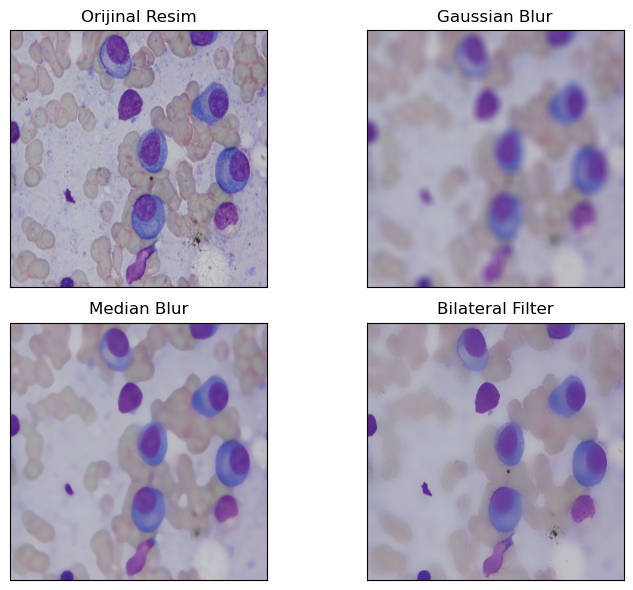

In [5]:
# Görüntüleri yan yana gösterme
# 2 satır, 2 sütunluk bir subplot oluşturma
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Resimleri subplotlara yerleştirme
axs[0, 0].imshow(img)
axs[0, 1].imshow(gaussian_blur)
axs[1, 0].imshow(median_blur)
axs[1, 1].imshow(bilateral_filter)

# Resimlere başlık verme
axs[0, 0].set_title('Orijinal Resim')
axs[0, 1].set_title('Gaussian Blur')
axs[1, 0].set_title('Median Blur')
axs[1, 1].set_title('Bilateral Filter')

# Eksen isimlerini kaldırma (isteğe bağlı)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

# Görüntüyü gösterme
plt.tight_layout()
plt.show()

In [6]:
img_blur = median_blur.copy()

## Normalizasyon

Farklı normalizasyon yöntemleri denenmiş ve proje için en uygun olanı Min-Max normalizasyon olduğu tespit edilmiştir. Bir görüntüdeki piksel değerlerini 0 ile 1 arasına sıkıştırarak, görüntünün genel parlaklık dağılımını yeniden düzenler. Bu işlem, görüntüdeki kontrastı dengeleyebilir, çünkü orijinaldeki düşük ve yüksek parlaklık değerleri daha eşit bir aralığa yayılır. Sonuç olarak, daha homojen bir aydınlık seviyesi elde edilir.

In [7]:
# Min-Max Normalization
norm_image = cv2.normalize(img_blur, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


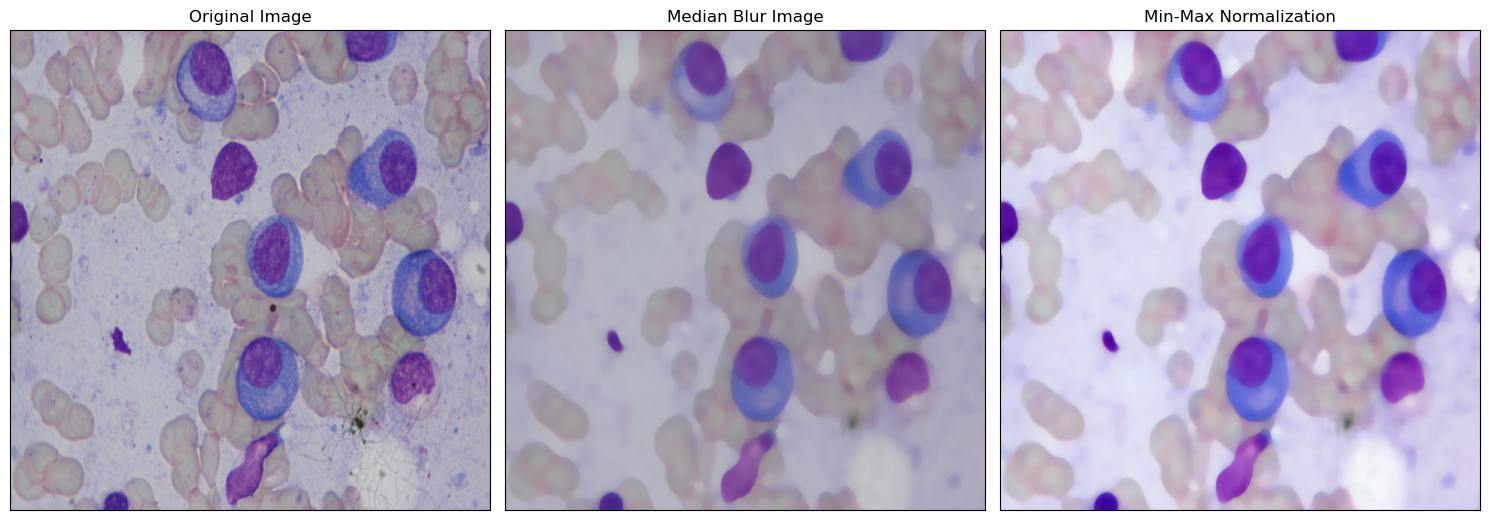

In [8]:
# Görüntüleri yan yana gösterme
# 2 satır, 2 sütunluk bir subplot oluşturma
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Resimleri subplotlara yerleştirme
axs[0].imshow(img)
axs[1].imshow(img_blur)
axs[2].imshow(norm_image)

# Resimlere başlık verme
axs[0].set_title('Original Image')
axs[1].set_title('Median Blur Image')
axs[2].set_title('Min-Max Normalization')

# Eksen isimlerini kaldırma (isteğe bağlı)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

# Görüntüyü gösterme
plt.tight_layout()
plt.show()

## Histogram eşitleme

Normalize edilmiş görüntünün hücrelerin çekirdeğini ve çeperini belirli bir tona getirdik. Görüntüdeki parlaklık ve kontrast dengesizliklerini gidermek için histogram eşitleme kullanılmıştır. LAB renk uzayında histogram eşitleme, tespit etmek istedğimiz hücreleri belirginleştiren en iyi yöntemdir. Renkli görüntüyü LAB renk uzayına dönüştürüp sadece parlaklık kanalı (L) üzerinde histogram eşitleme yaparak tespit etmek istedğimiz hücrenin çeperi ve çekirdeğini aynı renk tonuna getiririz.

In [9]:
# LAB Renk Uzayında Histogram Eşitleme
lab_image = cv2.cvtColor(norm_image, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab_image)

# Histogram Eşitleme sadece L kanalına uygulanır
l_equalized = cv2.equalizeHist(l)

# Kanalları birleştirip geri BGR formatına dönüştürme
lab_equalized = cv2.merge((l_equalized, a, b))
equalized_image = cv2.cvtColor(lab_equalized, cv2.COLOR_LAB2RGB)


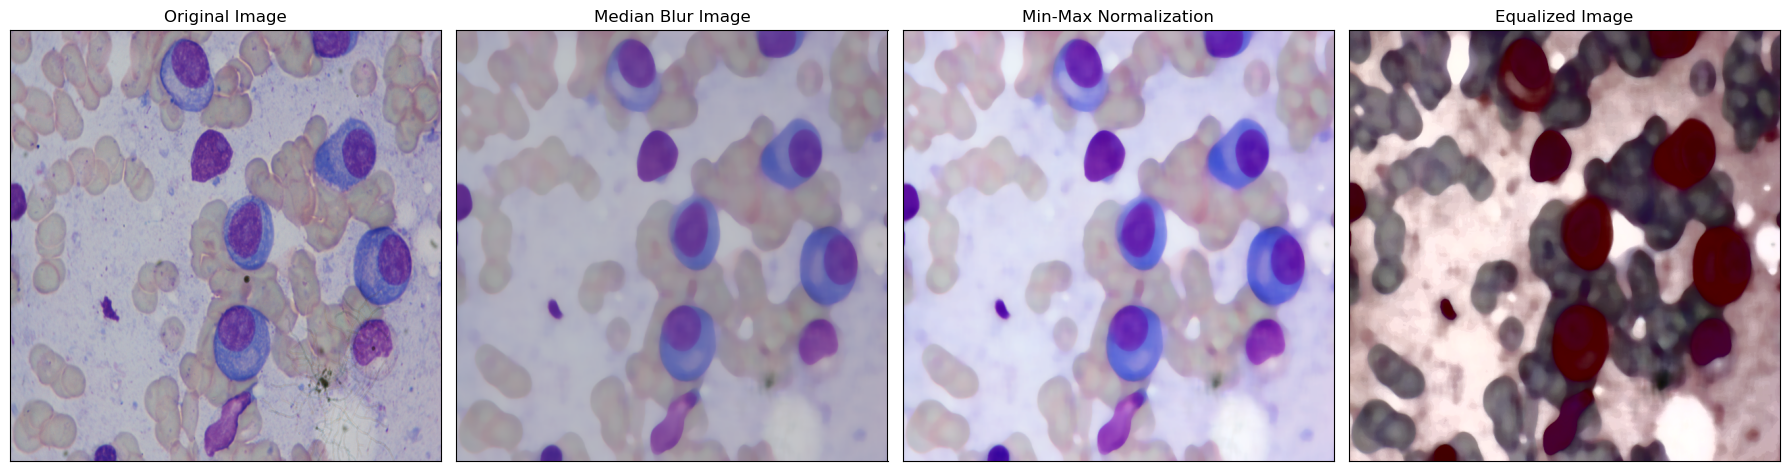

In [10]:
# Görüntüleri yan yana gösterme
# 2 satır, 2 sütunluk bir subplot oluşturma
fig, axs = plt.subplots(1, 4, figsize=(18, 6))

# Resimleri subplotlara yerleştirme
axs[0].imshow(img)
axs[1].imshow(img_blur)
axs[2].imshow(norm_image)
axs[3].imshow(equalized_image)

# Resimlere başlık verme
axs[0].set_title('Original Image')
axs[1].set_title('Median Blur Image')
axs[2].set_title('Min-Max Normalization')
axs[3].set_title('Equalized Image')

# Eksen isimlerini kaldırma (isteğe bağlı)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

# Görüntüyü gösterme
plt.tight_layout()
plt.show()

# 2.Hücre Tespiti

Renkleri normalize ederek hücrelerin çekirdeğini ve çeperini belirli bir tona getirmeniz, hücre tespitinde renk tabanlı segmentasyon için çok faydalı olacaktır. Bu durumda, bordo tonunu kullanarak hücreleri tespit etmek işimizi kolaylaştırabilir fakat bu yöntemin bazı problemleri vardır. Tanımlanan renk aralığına giren her bir rengin tespiti yapılacaktır. Bu durumda istenmeyen gürültüler de tespit edilecektir. Bu yöntem aşşağıda denenmiştir.

In [11]:
# HSV renk uzayına dönüştürme
hsv_image = cv2.cvtColor(equalized_image, cv2.COLOR_RGB2HSV)

# Bordo rengi için HSV aralığı
lower_bordo = np.array([140, 120, 0])
upper_bordo = np.array([220, 255, 120])

# Bordo tonunu maskeleme
mask = cv2.inRange(hsv_image, lower_bordo, upper_bordo)


# Maskenin 3 kanala dönüştürülmesi
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

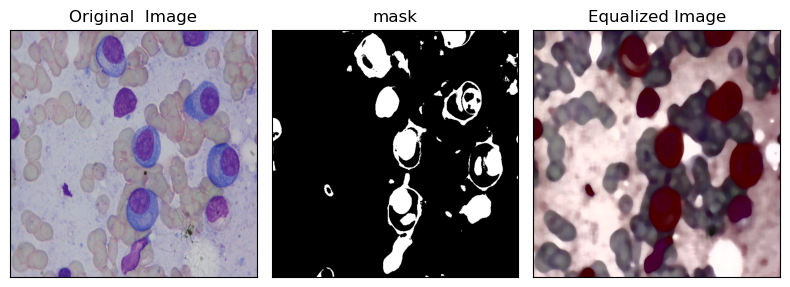

In [12]:
# Görüntüleri yan yana gösterme
# 2 satır, 2 sütunluk bir subplot oluşturma
fig, axs = plt.subplots(1,3, figsize=(8, 6))

# Resimleri subplotlara yerleştirme
axs[0].imshow(img)
axs[1].imshow(mask, cmap = "gray")
axs[2].imshow(equalized_image)

# Resimlere başlık verme
axs[0].set_title('Original  Image')
axs[1].set_title('mask')
axs[2].set_title('Equalized Image')

# Eksen isimlerini kaldırma (isteğe bağlı)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

# Görüntüyü gösterme
plt.tight_layout()
plt.show()

İstenilen sonuca ulaşılamadığı için daha sorna görüntü segmentasyonu için sıkça kullanılan GMM (Gaussian Mixture Model) adı verilen bir istatistiksel yöntem kullanılmıştır. GMM, bir veri setinin (bizim senaryo için mikroskop görüntüleri), genellikle farklı sınıflara ait olan alt gruplarını modellemek için birden fazla Gauss dağılımını kullanır. Hücre segmentasyonu gibi bir senaryoda, GMM’i kullanarak hücreleri farklı sınıflara (örneğin hücre çekirdeği, hücre çeperi, arka plan) ayırabiliriz.

In [13]:
# HSV renk uzayına dönüştür
hsv_image = cv2.cvtColor(equalized_image, cv2.COLOR_BGR2HSV)

h, w, _ = equalized_image.shape

# HSV renk kanallarını ve piksel koordinatlarını birleştir
X = hsv_image.reshape(-1, 3)  # Renk özellikleri

In [14]:
# GMM modelini tanımla (örneğin 3 sınıf: çekirdek, çeper, arka plan)
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)

# Modeli eğit
gmm.fit(X)

GaussianMixture(n_components=3, random_state=42)

In [15]:
# Her pikselin sınıfını tahmin et
labels = gmm.predict(X)

# Renk ortalaması (hedef renk)
target_color = np.array([126.49791953, 255.0, 70.80896763])

# Modelin her sınıfının ortalama rengini al
means = gmm.means_

# Ortalama renkleri yazdır
print("Sınıf Ortalama Renkleri (Mu):")
print(means)

# Euclidean mesafesini hesapla
distances = np.linalg.norm(means - target_color, axis=1)

# En yakın sınıfın indeksini bul
core_class = np.argmin(distances)
print("core_class", core_class)

# Sonuçları yeniden görüntü boyutuna dönüştür
segmented_image = labels.reshape(h, w)


Sınıf Ortalama Renkleri (Mu):
[[142.8041831   62.85742775  95.03182609]
 [121.69439148  32.70885993 211.18815973]
 [126.49791953 255.          70.80896763]]
core_class 2


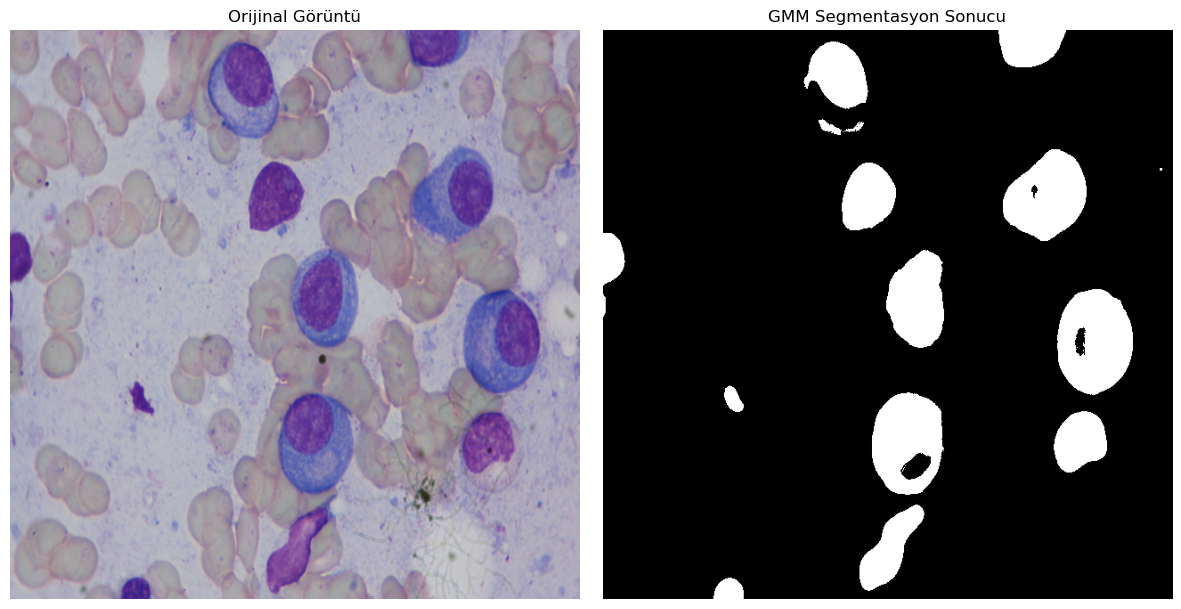

In [16]:
# Çekirdek sınıfını seç (örneğin sınıf 1)
nucleus_mask = (segmented_image == core_class).astype(np.uint8) * 255

# Görselleştirme
plt.figure(figsize=(12, 6))

# Orijinal görüntü
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Orijinal Görüntü")
plt.axis("off")

# Segmentasyon sonucu
plt.subplot(1, 2, 2)
plt.imshow(nucleus_mask.astype(np.uint8), cmap="gray")
plt.title("GMM Segmentasyon Sonucu")
plt.axis("off")

plt.tight_layout()
plt.show()

# 3.Morfolojik İşlemler

Sonraki adımda, morfolojik işlemler uygulanır. Morfolojik işlemler, bir görüntü üzerinde belirli şekilleri manipüle etmek için kullanılır. Açma (Opening) ve Kapama (Closing) işlemleri kullanılmıştır. İlk olarak Açma, gürültüyü ve küçük nesneleri ortadan kaldırır. Sonra Kapama, bu temizlenmiş görüntüyü daha düzgün hale getirir ve küçük boşlukları doldurur.

In [17]:
mask = nucleus_mask.copy()

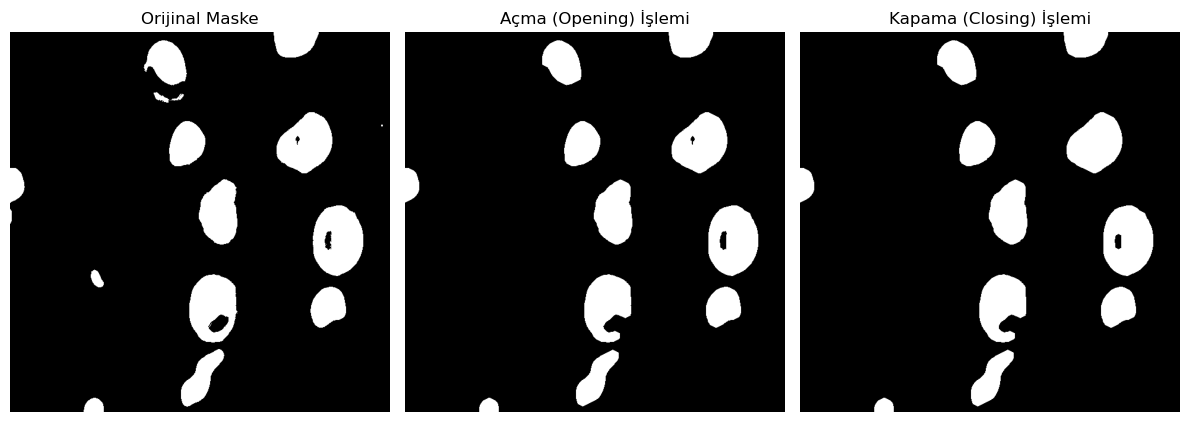

In [18]:
# Morfolojik çekirdek oluşturma (örneğin elips şekilli çekirdek)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Çekirdek boyutu 5x5

# Açma işlemi (Opening)
opened = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=4)

# Kapama işlemi (Closing)
closed = cv2.morphologyEx(opened.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=2)

# Sonuçları görselleştirme
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(mask, cmap="gray")
plt.title("Orijinal Maske")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(opened, cmap="gray")
plt.title("Açma (Opening) İşlemi")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(closed, cmap="gray")
plt.title("Kapama (Closing) İşlemi")
plt.axis("off")

plt.tight_layout()
plt.show()


Elde edilen maskeyi morfolojik işlemler ile daha iyi bir hale getirebilmek için önce, bir maskenin dış çerçevesindeki boşlukları doldurmak için Flood Fill işlemi yapılır. Bu şekilde kenarları belli olan hücrelerin iç kısımları doldurulur.

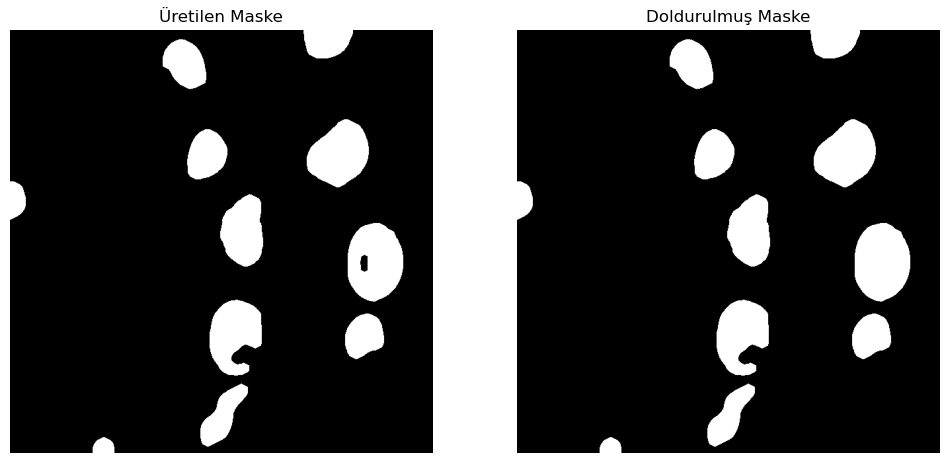

In [19]:
# Flood fill için bir kopya oluştur ve dış çerçeveyi beyaz yap
filled_mask = closed.copy()

# Kenarları beyaz yapın (dış çerçeveyi)
filled_mask[0, :] = 0
filled_mask[-1, :] = 0
filled_mask[:, 0] = 0
filled_mask[:, -1] = 0

h, w = filled_mask.shape
cv2.floodFill(filled_mask, None, (0, 0), 255)  # (0,0) başlangıç noktası

# Dıştaki alanları ters çevir ve orijinal maskeyle birleştir
filled_holes = cv2.bitwise_or(closed, cv2.bitwise_not(filled_mask))


# Görselleştirme
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(closed, cmap="gray")
plt.title("Üretilen Maske")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(filled_holes, cmap="gray")
plt.title("Doldurulmuş Maske")
plt.axis("off")

plt.show()

# 4.Test Aşaması

In [20]:
def cellDetection(img_name):
  # Resim Yolu
  image_path = f"C:/dev/cv/cell-segmentation-image-processing/DB/{img_name}.bmp"

  # Resmi okuma
  img = cv2.imread(image_path)

  # Hız için yeniden boyutlandır
  img = resize_img(img)

  # BGR'den RGB'ye dönüştürme (Matplotlib'in varsayılanı RGB'dir)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Median Blur
  img_blur = cv2.medianBlur(img, 17)

  # Min-Max Normalization
  norm_image = cv2.normalize(img_blur, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

  # LAB Renk Uzayında Histogram Eşitleme
  lab_image = cv2.cvtColor(norm_image, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab_image)

  # Histogram Eşitleme sadece L kanalına uygulanır
  l_equalized = cv2.equalizeHist(l)

  # Kanalları birleştirip geri BGR formatına dönüştürme
  lab_equalized = cv2.merge((l_equalized, a, b))
  equalized_image = cv2.cvtColor(lab_equalized, cv2.COLOR_LAB2RGB)

  # HSV renk uzayına dönüştür
  hsv_image = cv2.cvtColor(equalized_image, cv2.COLOR_BGR2HSV)

  h, w, _ = equalized_image.shape

  # HSV renk kanallarını ve piksel koordinatlarını birleştir
  X = hsv_image.reshape(-1, 3)  # Renk özellikleri



  # GMM modelini tanımla (örneğin 3 sınıf: çekirdek, çeper, arka plan)
  gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)

  # Modeli eğit
  gmm.fit(X)


    # Her pikselin sınıfını tahmin et
  labels = gmm.predict(X)

  # Renk ortalaması (hedef renk)
  target_color = np.array([126.49791953, 255.0, 70.80896763])

  # Modelin her sınıfının ortalama rengini al
  means = gmm.means_


  # Euclidean mesafesini hesapla
  distances = np.linalg.norm(means - target_color, axis=1)

  # En yakın sınıfın indeksini bul
  core_class = np.argmin(distances)

  # Sonuçları yeniden görüntü boyutuna dönüştür
  segmented_image = labels.reshape(h, w)

  # Çekirdek sınıfını seç (örneğin sınıf 1)
  nucleus_mask = (segmented_image == core_class).astype(np.uint8) * 255

  mask = nucleus_mask.copy()

  # Morfolojik çekirdek oluşturma (örneğin elips şekilli çekirdek)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Çekirdek boyutu 5x5

  # Açma işlemi (Opening)
  opened = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=4)

  # Kapama işlemi (Closing)
  closed = cv2.morphologyEx(opened.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=2)

  # Flood fill için bir kopya oluştur ve dış çerçeveyi beyaz yap
  filled_mask = closed.copy()

  # Kenarları siyah yapın (dış çerçeveyi)
  filled_mask[0, :] = 0
  filled_mask[-1, :] = 0
  filled_mask[:, 0] = 0
  filled_mask[:, -1] = 0


  h, w = filled_mask.shape
  cv2.floodFill(filled_mask, None, (0, 0), 255)  # (0,0) başlangıç noktası

  # Dıştaki alanları ters çevir ve orijinal maskeyle birleştir
  filled_holes = cv2.bitwise_or(closed, cv2.bitwise_not(filled_mask))

  return filled_holes


In [21]:
# IoU değerini hesaplamak için python fonksiyonu
def iou(mask_a, mask_b):
  if len(mask_b.shape) == 3:
    mask_b = cv2.cvtColor(mask_b, cv2.COLOR_BGR2GRAY)

  # Kesişim (Intersection)
  intersection = np.sum(np.logical_and(mask_a, mask_b))

  # Birleşim (Union)
  union = np.sum(np.logical_or(mask_a, mask_b))

  # IoU hesapla
  iou_value = intersection / union

  return iou_value



10 Adet mikroskop görüntüsü için görüntü işleme tekniklerini uygular. IOU'ları hesaplar ve ortalamasını gösterir.

cell_00001 için IOU: 0.8305
cell_00002 için IOU: 0.7141
cell_00003 için IOU: 0.7072
cell_00004 için IOU: 0.6088
cell_00005 için IOU: 0.6556
cell_00006 için IOU: 0.9093
cell_00007 için IOU: 0.7373
cell_00008 için IOU: 0.8854
cell_00009 için IOU: 0.8612
cell_00010 için IOU: 0.8149

Ortalama IOU: 0.7724


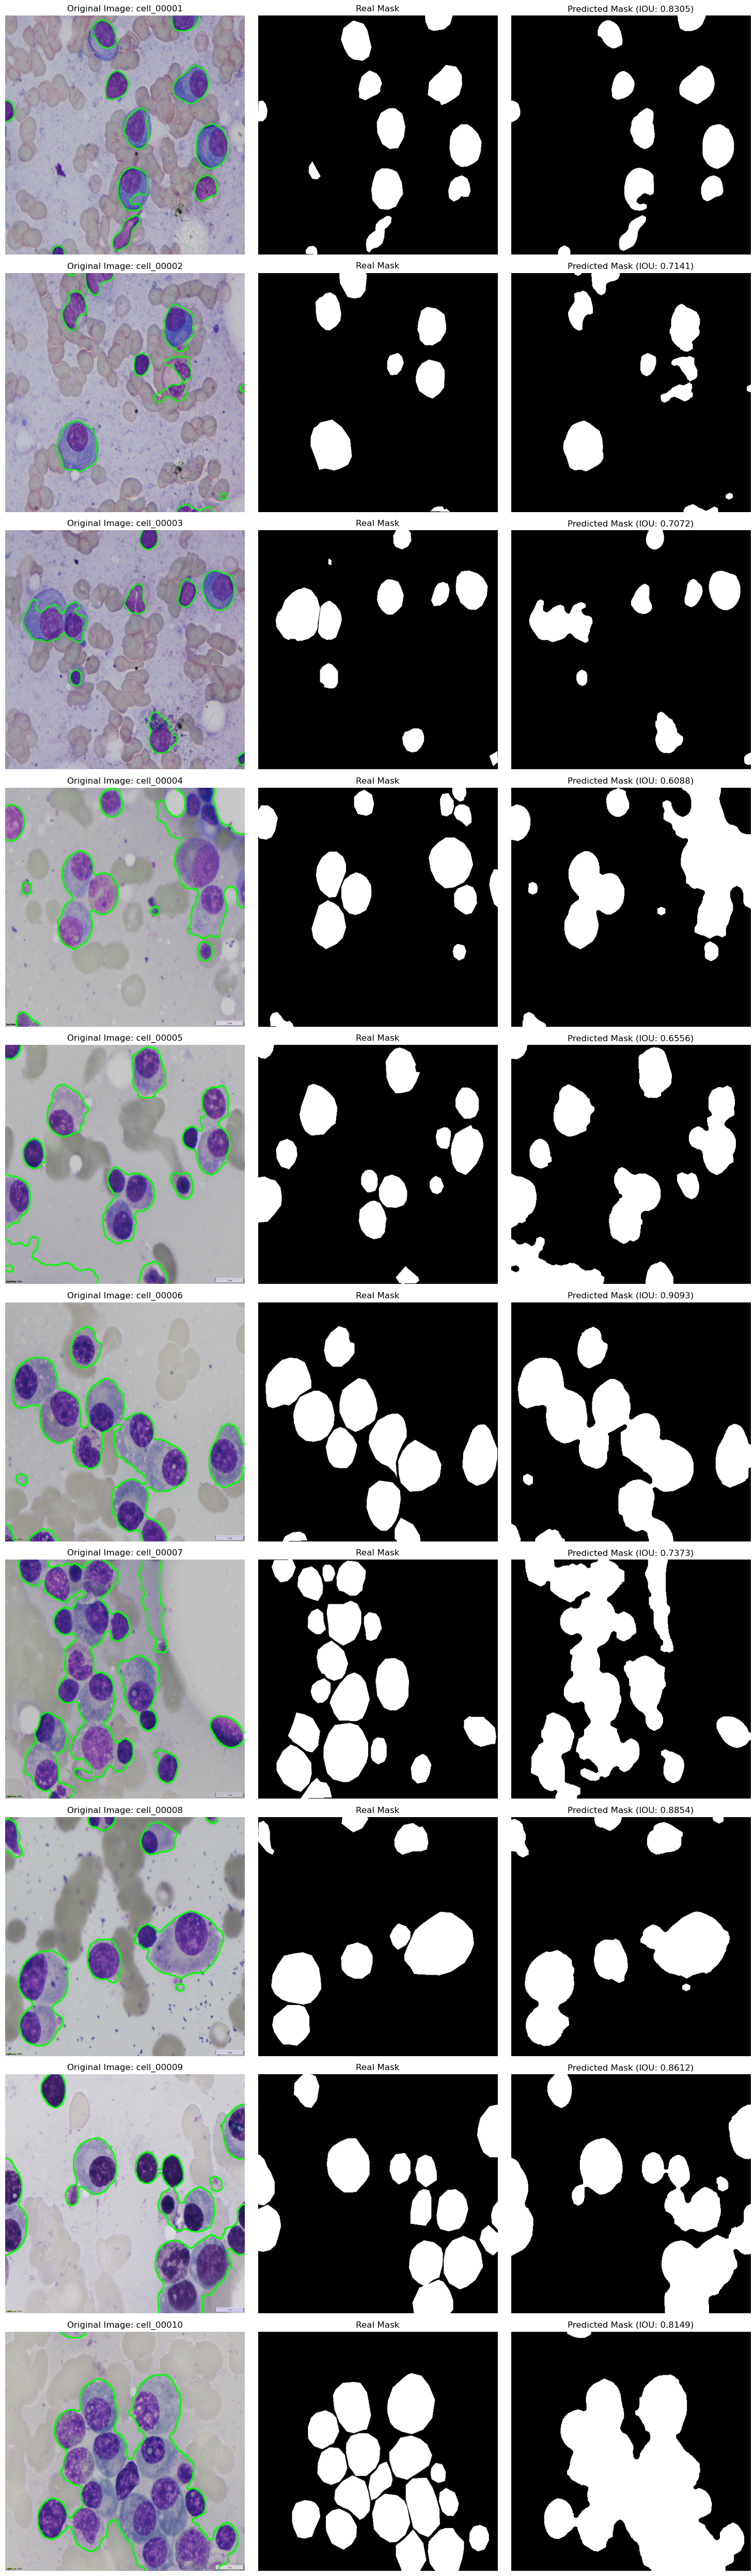

In [22]:
# Test için kullanılacak görüntü ve maske isimleri
image_names = [f"cell_000{str(i).zfill(2)}" for i in range(1, 11)]

# Görselleştirme
fig, axes = plt.subplots(len(image_names), 3, figsize=(15, 5 * len(image_names)))

# IOU hesaplama ve ortalamayı bulma
iou_scores = []

for idx, img_name in enumerate(image_names):
    real_mask = cv2.imread(f"C:/dev/cv/cell-segmentation-image-processing/DB/{img_name}.png")
    real_mask = resize_img(real_mask)

    predicted_mask = cellDetection(img_name)

    original_image = cv2.imread(f"C:/dev/cv/cell-segmentation-image-processing/DB/{img_name}.bmp")
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image = resize_img(original_image)

    score = iou(predicted_mask, real_mask)
    iou_scores.append(score)
    print(f"{img_name} için IOU: {score:.4f}")


    # Maskenin boyutunu orijinal resimle uyumlu hale getir
    mask_resized = cv2.resize(predicted_mask, (original_image.shape[1], original_image.shape[0]))

    # Maskeyi orijinal resme uygula
    masked_image = cv2.bitwise_and(original_image, original_image, mask=mask_resized)

    # Kenarları tespit et (Canny yöntemiyle)
    edges = cv2.Canny(mask_resized, 100, 200)

    # Kenarları orijinal resim üzerinde çiz
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = original_image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)  # Yeşil renk ile kenarları çiz


    # Görüntüleri görselleştirme
    axes[idx, 0].imshow(image_with_contours)
    axes[idx, 0].set_title(f"Original Image: {img_name}")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(real_mask)
    axes[idx, 1].set_title("Real Mask")
    axes[idx, 1].axis("off")

    axes[idx, 2].imshow(predicted_mask, cmap = "gray")
    axes[idx, 2].set_title("Predicted Mask" + f" (IOU: {score:.4f})")
    axes[idx, 2].axis("off")

average_iou = np.mean(iou_scores)
print(f"\nOrtalama IOU: {average_iou:.4f}")

# Alt grafikler arasında boşluk bırakma
plt.tight_layout()
plt.show()